## Question 2

In [1]:
# Binary classification
# Emulate the XOR logical gate
# 1 hidden layer

import numpy as np
import pandas as pd

# Define the AND dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y = np.array([[0, 0, 0, 1]], dtype=np.float32)

# Define size parameters
hidden_size = 5
input_size = 2
output_size = 1

# Set seed to make it reproduceable
np.random.seed(1)

# Random initialization
W1 = np.random.randn(hidden_size, input_size)
b1 = np.zeros((hidden_size, 1))
W2 = np.random.randn(output_size, hidden_size)
b2 = np.zeros((output_size, 1))

def relu(z):
    return np.maximum(0, z)

def d_relu(z):
    return np.where(z > 0, 1, 0)

def forward(x, W1, W2, b1, b2):
    z1 = np.dot(W1, x) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    return a1, a2

def loss(a2, y):
    return np.mean((np.squeeze(a2)-y)**2)

def back_prop(x, y, a1, a2, W1, W2):
    dz2 = (a2 - y)
    dw2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims=True)
    
    dz1 = np.multiply(np.dot(W2.T, dz2), d_relu(a1))
    dw1 = np.dot(dz1, x.T)
    db1 = np.sum(dz1, axis=1, keepdims=True)

    return dw1, db1, dw2, db2

def update_weights(W1, b1, W2, b2, dw1, db1, dw2, db2, learning_rate):
    W1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dw2
    b2 -= learning_rate * db2



In [2]:
X.shape[1]

2

In [3]:
epochs = 10000
learning_rate = 0.1

for epoch in range(epochs):
    a1, a2= forward(X.T, W1, W2, b1, b2)
    cost = loss(a2, y)
    
    dw1, db1, dw2, db2 = back_prop(X.T, y, a1, a2, W1, W2)
    update_weights(W1, b1, W2, b2, dw1, db1, dw2, db2, learning_rate)
    
    if epoch % 1000 == 0:
        print(f"Loss: {cost}")

# Test the model
test_input = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
_, predictions = forward(test_input.T,  W1, W2, b1, b2)
predictions = np.round(predictions)  # Apply threshold
print(f"Predictions: {predictions}")



Loss: 0.8071006335864577
Loss: 5.789826895314128e-33
Loss: 5.789826895314128e-33
Loss: 5.789826895314128e-33
Loss: 5.789826895314128e-33
Loss: 5.789826895314128e-33
Loss: 5.789826895314128e-33
Loss: 5.789826895314128e-33
Loss: 5.789826895314128e-33
Loss: 5.789826895314128e-33
Predictions: [[0. 0. 0. 1.]]


## Question 3

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

iris = load_iris()

In [54]:
# Split the data into training and testing sets
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the target variable
# Ideal since output of NN is a vector of probabilities
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()


In [55]:
# Build
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

Architecture summary:
- 3 layers
- Input dim: 4. There are 4 features.
- Input layer has 8 neurons: found through trial and error. Started with 64, divided by 2 every time. All achieved 100% accuracy with minimal increase in loss. Thus, it is obvious that the simpler architecture is better.
- Hidden layer has 8 neurons: found through trial and error: found through trial and error. Started with 64, divided by 2 every time. All achieved 100% accuracy with minimal increase in loss. Thus, it is obvious that the simpler architecture is better.
- Output layer has 3 neurons: we are predicting the probability that a data point will belong into 1 of 3 classes. Thus, 3 output neurons are needed

Hyperparameter Selection:
- Activation: ReLU avoids the vanishing gradient problem that sigmoid or tanh functions experience
- Activation for output layer: Softmax is able to generate a vector of probabilities used for classification, which the problem is.
- Optimizer: Adam uses adaptive learning rate for each parameter to prevent the gradient from oscilating due to incorrect learning rate, and it adds momentum to the gradient (add a small part of the previous gradient to the current one) to help the algorithm converge.
- Learning rate: it is typical to start with 0.01 as learning rate.
- Loss: Since we are solving a classification problem with more than 1 class, we want to use a cross entropy (log) loss. We use categorical because we one-hot encoded the response. If it hadn't been, sparse categorical cross entropy would be more appropriate.
- Metrics: Since we are solving a classification problem, accuracy would be the appropriate metric.
- Epochs: Ensures model is able to fully learn the patterns and not underfit. For added efficiency and decreased computation time, early stopping based on loss will be implemented.
- Batch size: 64 provides a balance between speed and memory requirements

In [56]:
# Early stopping criteria
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train 
# No val set
history = model.fit(X_train, y_train, batch_size=64, epochs=1000, verbose=0, callbacks = [callback])

# Testing
scores = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test result for accuracy: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

2/2 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 1.0000
Test result for accuracy: 100.000 loss: 0.028


In [34]:
# Random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train.argmax(axis=1))
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test.argmax(axis=1), y_pred_rf)

# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train.argmax(axis=1))
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test.argmax(axis=1), y_pred_xgb)

print(f"Accuracy using random forest classifier is {accuracy_rf}")
print(f"Accuracy using XGB classifier is {accuracy_xgb}")

Accuracy using random forest classifier is 1.0
Accuracy using XGB classifier is 1.0


XGB, RF, and NN all have 100% accuracy. This goes to show that sometimes simpler models can perform better than more complicated models, and is often prefered due to cost, efficiency, and running time.

## Question 4

In [40]:
import matplotlib.pyplot as plt

# Create sine function
x_train = np.random.uniform(-np.pi, np.pi, 1000)
y_train = np.sin(x_train)
x_test = np.linspace(-np.pi, np.pi, 100)

In [50]:
# Build the model
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=1))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

Architecture summary:
- 3 layers
- Input dim: 1. There is 1 feature
- Input layer has 16 neurons: found through trial and error. Started with 64 neurons, then 32, then 16. 16 neurons is a smaller architecture with almost as good performance as seen in the plot below.
- Hidden layer has 16 neurons: found through trial and error. Started with 64 neurons, then 32, then 16. 16 neurons is a smaller architecture with almost as good performance as seen in the plot below.
- Output layer has 1 neuron: output is 1 single number.

Hyperparameter Selection:
- Activation: ReLU avoids the vanishing gradient problem that sigmoid or tanh functions experience
- Activation for output layer: Since we are solving a regression problem, the output activation should be linear as the values are unbounded, unlike classification problem where we need the probabilities
- Learning rate: it is typical to start with 0.01 as learning rate.
- Loss: Since we are solving a regression problem, MSE is an appropriate loss function
- Epochs: 1000 ensures model is able to fully learn the patterns and not underfit.
- Batch size: 64 provides a balance between speed and memory requirements

4/4 [==============================] - 0s 701us/step


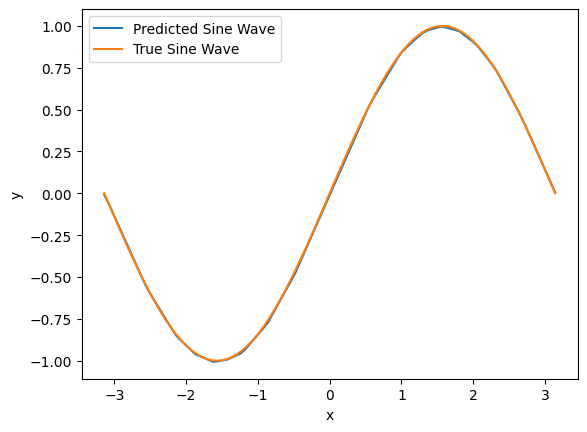

In [51]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=1000, verbose=0)

# Predict and plot the learned mapping
y_pred = model.predict(x_test)

plt.plot(x_test, y_pred, label='Predicted Sine Wave')
plt.plot(x_test, np.sin(x_test), label='True Sine Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()